In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio


@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav



In [5]:
class ExportModel(tf.Module):
    def __init__(self, model, labels):
        self.model = model
        self.label_names = labels
        # Accept either a string-filename or a batch of waveforms.
        # YOu could add additional signatures for a single wave, or a ragged-batch. 
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))
        
    def get_spectrogram(self, waveform):
        # Convert the waveform to a spectrogram via a STFT (Short-Time Fourier Transform)
        spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
        # Obtain the magnitude of the STFT.
        spectrogram = tf.abs(spectrogram)
        # Add a `channels` dimension, so that the spectrogram can be used
        # as image-like input data with convolution layers (which expect
        # shape (`batch_size`, `height`, `width`, `channels`).
        spectrogram = spectrogram[..., tf.newaxis]
        return spectrogram

    @tf.function
    def __call__(self, x):
    # If they pass a string, load the file and decode it. 
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]
        x = self.get_spectrogram(x)  
        result = self.model(x, training=False)
        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(self.label_names, class_ids)
        return {'predictions':result,
                'class_ids': class_ids,
                'class_names': class_names}

def get_mini_speech_dataset():
  DATASET_PATH = 'data/mini_speech_commands'
  data_dir = os.path.join()
  if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [ ]:
# import os
# import glob
# import random
# import shutil

# import librosa
# import soundfile as sf
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# import tensorflow as tf


# # Create a list of all the background wav files
# files = glob.glob(os.path.join('./dataset-speech/_background_noise_', '*.wav'))
# files = files + glob.glob(os.path.join('./dataset-background', '*.wav'))

# background_dir = './background'
# os.makedirs(background_dir, exist_ok=True)

# # Loop through all files and split each into several one-second wav files
# for file in files:
#   filename = os.path.basename(os.path.normpath(file))
#   print('Splitting', filename)
#   name = os.path.splitext(filename)[0]
#   rate = librosa.get_samplerate(file)
#   length = round(librosa.get_duration(filename=file))
#   for i in range(length - 1):
#     start = i * rate
#     stop = (i * rate) + rate
#     data, _ = sf.read(file, start=start, stop=stop)
#     sf.write(os.path.join(background_dir, name + str(i) + '.wav'), data, rate)

In [12]:
import os
import numpy as np
import tensorflow as tf
import scipy.signal as sps
from scipy.io import wavfile
import matplotlib.pyplot as plt



down_dirs = os.path.join(os.getcwd(), "data", "mini_speech_commands", "down")
file_list = [os.path.join(down_dirs, fname) for fname in os.listdir(down_dirs)]

f0 = file_list[1]

# with open(f0, "rb") as fh:
#     data = np.array(fh.read())

# print(data)

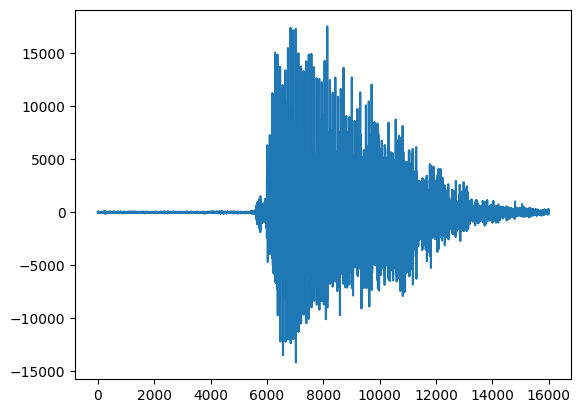

In [13]:
def load_wav_16k_mono(fname):
    sample_rate, data = wavfile.read(fname)
    rate_out=16000
    n_samples = round(len(data) * rate_out / sample_rate)
    wav = sps.resample(data, n_samples)
    return wav

data = load_wav_16k_mono(f0)

plt.plot(data)